NEW CODE


In [ ]:
!pip install alpha_vantage
!pip install fix_yahoo_finance
!pip install ffn
#!pip install ta
!pip install backtesting

In [ ]:
#ticker = 'SCHD'
#data = yf.download(ticker, start='2015-01-01', end='2024-01-01', actions=True)

#if 'Adj Close' not in data.columns:
    #print("Adjusted Close column not found; using Close column instead.")
    #data['Adj Close'] = data['Close']  # Use 'Close' as fallback

[*********************100%***********************]  1 of 1 completed


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib notebook
import pandas as pd
#from alpha_vantage.timeseries import TimeSeries
import fix_yahoo_finance as yf
#because the is_list_like is moved to pandas.api.types
#pd.core.common.is_list_like = pd.api.types.is_list_like
#import ffn
#import pixiedust
#import yfinance as yf


#from ta.momentum import RSIIndicator
#from ta.volatility import BollingerBands

/usr/local/lib/python3.10/dist-packages/fix_yahoo_finance/__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



We already have dowlaoded Our data

In [ ]:
#ticker = 'SCHD'
#data = yf.download(ticker, start='2020-10-01', end='2024-11-20', actions=True)
#data.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
#data['Adj_Open']=data.Open*(data.Adj_Close/data.Close)
#data.to_csv('SCHD_data.csv')


data = pd.read_csv("schd_data.csv")
data.head()


,Date,Adj_Close,Capital Gains,Close,Dividends,High,Low,Open,Stock Splits,Volume
0,2020-10-01 00:00:00+00:00,13.840476,0,18.423332,0.0,18.586666,18.293333,18.526667,0,4379700
1,2020-10-02 00:00:00+00:00,13.903079,0,18.506666,0.0,18.610001,18.123333,18.146667,0,6087900
2,2020-10-05 00:00:00+00:00,14.206082,0,18.910000,0.0,18.936666,18.673332,18.673332,0,3478500
3,2020-10-06 00:00:00+00:00,14.113428,0,18.786667,0.0,19.236668,18.746668,18.983334,0,4992900
4,2020-10-07 00:00:00+00:00,14.401407,0,19.170000,0.0,19.209999,18.959999,18.959999,0,3791700


In [ ]:
# Step 1: Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Sort the data by date to ensure chronological order
data.sort_index(inplace=True)

# Step 2: Add cumulative dividends column
# Calculate cumulative dividends for reinvestment tracking
data['Cumulative Dividends'] = data['Dividends'].cumsum()

# Step 3: Calculate technical indicators
# Bollinger Bands
data['20 MA'] = data['Adj_Close'].rolling(window=20).mean()
data['20 STD'] = data['Adj_Close'].rolling(window=20).std()
data['BB High'] = data['20 MA'] + (2 * data['20 STD'])
data['BB Low'] = data['20 MA'] - (2 * data['20 STD'])
# drops rows with NaN values caused by rolling calculations
data.dropna(inplace=True)
data.head()

,Adj_Close,Capital Gains,Close,Dividends,High,Low,Open,Stock Splits,Volume,Cumulative Dividends,20 MA,20 STD,BB High,BB Low
Date,,,,,,,,,,,,,,
2020-10-28 00:00:00+00:00,13.722778,0,18.266666,0.0,18.606667,18.243334,18.500000,0,7518900,0.0,14.408420,0.312818,15.034056,13.782783
2020-10-29 00:00:00+00:00,13.903079,0,18.506666,0.0,18.636667,18.086666,18.226667,0,5783400,0.0,14.411550,0.307097,15.025744,13.797356
2020-10-30 00:00:00+00:00,13.900576,0,18.503332,0.0,18.520000,18.226667,18.393333,0,6378000,0.0,14.411424,0.307316,15.026056,13.796793
2020-11-02 00:00:00+00:00,14.211093,0,18.916668,0.0,18.953333,18.629999,18.750000,0,4733700,0.0,14.411675,0.307141,15.025958,13.797392
2020-11-03 00:00:00+00:00,14.464013,0,19.253332,0.0,19.356667,19.113333,19.139999,0,4990500,0.0,14.429204,0.299124,15.027451,13.830957


In [ ]:
# Initialize variables for strategy simulation
initial_cash = 10_000
cash = initial_cash
shares = 0
portfolio_values = []
#########################################
#Choose strategy backtest time frame
start_date = '2021-01-01'
end_date = '2024-01-01'
subset_data = data.loc[start_date:end_date]
#########################################

# Iterate through each row to simulate the strategy
for i, row in data.iterrows():
    # If the adjusted close price is below the lower Bollinger Band, buy
    if row['Adj_Close'] < row['BB Low']:
        shares_to_buy = cash // row['Adj_Close']
        cash -= shares_to_buy * row['Adj_Close']
        shares += shares_to_buy

    # If the adjusted close price is above the upper Bollinger Band, sell
    elif row['Adj_Close'] > row['BB High'] and shares > 0:
        cash += shares * row['Adj_Close']
        shares = 0

    # Add dividend reinvestment
    if shares > 0:
        reinvested_shares = (shares * row['Dividends']) // row['Adj_Close']
        shares += reinvested_shares

    # Calculate portfolio value and store it
    portfolio_value = cash + shares * row['Adj_Close']
    portfolio_values.append(portfolio_value)

# Add portfolio values to the DataFrame
data['Portfolio Value'] = portfolio_values

# Calculate buy-and-hold performance for comparison
buy_and_hold_shares = initial_cash // data.iloc[0]['Adj_Close']
buy_and_hold_cash = initial_cash - (buy_and_hold_shares * data.iloc[0]['Adj_Close'])
data['Buy and Hold Value'] = buy_and_hold_cash + buy_and_hold_shares * data['Adj_Close']

# Display the last few rows of the simulation results
data[['Portfolio Value', 'Buy and Hold Value']]

,Portfolio Value,Buy and Hold Value
Date,,
2020-10-28 00:00:00+00:00,10000.000000,10000.000000
2020-10-29 00:00:00+00:00,10131.258917,10131.258917
2020-10-30 00:00:00+00:00,10129.436449,10129.436449
2020-11-02 00:00:00+00:00,10355.493051,10355.493051
2020-11-03 00:00:00+00:00,10539.618920,10539.618920
...,...,...
2024-11-13 00:00:00+00:00,16336.198385,21129.097550
2024-11-14 00:00:00+00:00,16336.198385,21034.456772
2024-11-15 00:00:00+00:00,16336.198385,20852.456772


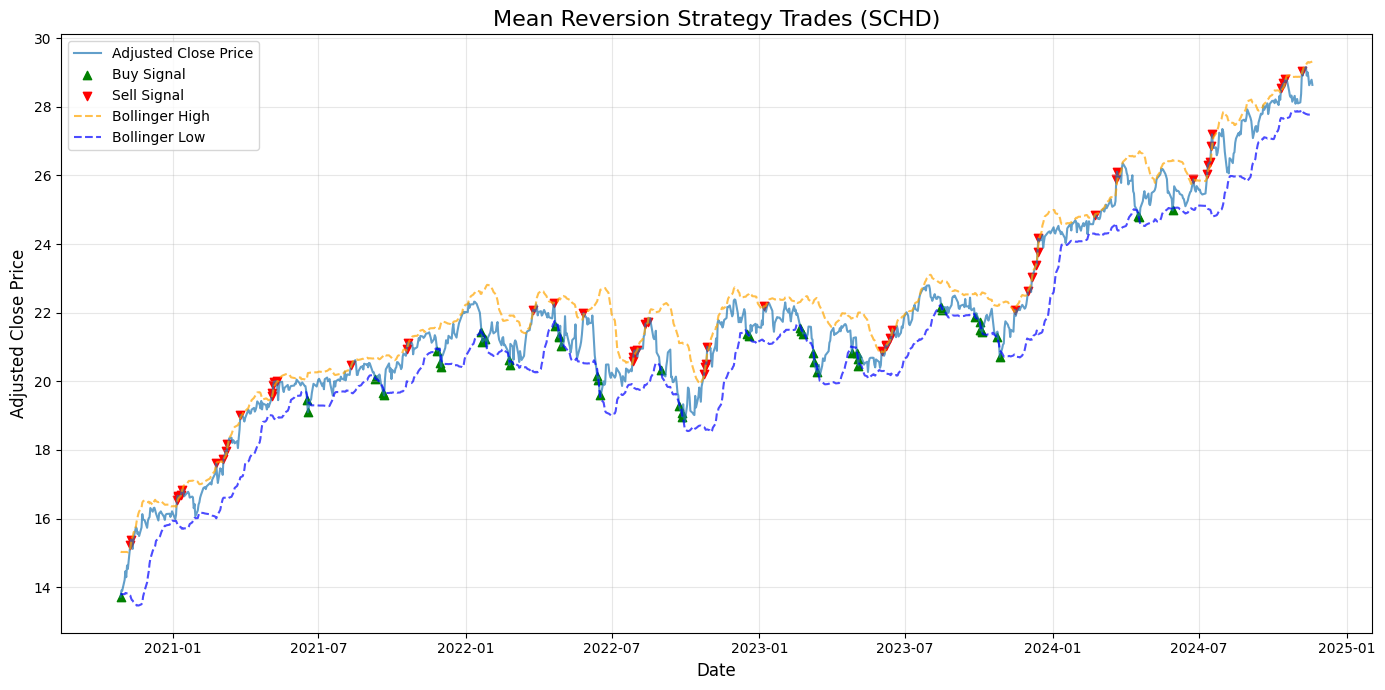

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Create a plot for visualization
plt.figure(figsize=(14, 7))

# Plot Adjusted Close prices
plt.plot(data.index, data['Adj_Close'], label='Adjusted Close Price', alpha=0.7)

# Highlight buy signals
buy_signals = data[data['Adj_Close'] < data['BB Low']]
plt.scatter(buy_signals.index, buy_signals['Adj_Close'], label='Buy Signal', marker='^', color='green', alpha=1)

# Highlight sell signals
sell_signals = data[data['Adj_Close'] > data['BB High']]
plt.scatter(sell_signals.index, sell_signals['Adj_Close'], label='Sell Signal', marker='v', color='red', alpha=1)

# Add Bollinger Bands
plt.plot(data.index, data['BB High'], label='Bollinger High', linestyle='--', color='orange', alpha=0.7)
plt.plot(data.index, data['BB Low'], label='Bollinger Low', linestyle='--', color='blue', alpha=0.7)

# Add labels and legend
plt.title('Mean Reversion Strategy Trades (SCHD)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.savefig("mean_reversion_trades.png")
plt.show()


Okay lets Incorporate some ML Technique to enhance our analysis by predicting price movements, refining entry/exit signals, or adapting the strategy based on evolving market conditions.

In [ ]:
#data['Daily Return'] = data['Adj_Close'].pct_change()
#data['RSI'] = 100 - (100 / (1 + (data['Daily Return'].rolling(14).mean() /  abs(data['Daily Return'].rolling(14).mean()))))



In [ ]:
data['Gain'] = data['Daily Return'].apply(lambda x: x if x > 0 else 0)
data['Loss'] = data['Daily Return'].apply(lambda x: abs(x) if x < 0 else 0)
avg_gain = data['Gain'].rolling(window=14).mean()
avg_loss = data['Loss'].rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))


In [ ]:
# Example target labeling
data['Target'] = 0
data.loc[data['Adj_Close'].shift(-1) > data['Adj_Close'], 'Target'] = 1
data.loc[data['Adj_Close'].shift(-1) < data['Adj_Close'], 'Target'] = -1


In [ ]:
#data.head()

In [ ]:
from sklearn.model_selection import train_test_split

# Select features and target
X = data[['Adj_Close','Volume', '20 MA', '20 STD', 'BB High', 'BB Low', 'RSI', 'Daily Return']]
y = data['Target']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Train an ML Model
Use a classification model like Random Forest or Gradient Boosting:

In [ ]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute or drop NaN values
# Option 1: Impute with the mean
# X_train.fillna(X_train.mean(), inplace=True)
# X_test.fillna(X_test.mean(), inplace=True)

# Option 2: Drop rows with NaN values
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]  # Adjust y_train accordingly
X_test.dropna(inplace=True)
y_test = y_test[X_test.index]  # Adjust y_test accordingly

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

#evaluates the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


from sklearn.metrics import precision_score

# calculates precision for Target == 1 (profitable reversion opportunities)

precision = precision_score(y_test, y_pred, pos_label=1)
print(f"Precision for Profitable Reversions: {precision:.2f}")


Model Accuracy: 0.47
Precision for Profitable Reversions: 1.00


More Prepocessesing

In [ ]:
print(X.isna().sum())  # Check for missing values in each column
print(np.isinf(X).sum())  # Check for infinite values

Adj_Close        0
Volume           0
20 MA            0
20 STD           0
BB High          0
BB Low           0
RSI             13
Daily Return     0
dtype: int64
Adj_Close       0
Volume          0
20 MA           0
20 STD          0
BB High         0
BB Low          0
RSI             0
Daily Return    0
dtype: int64


In [ ]:
 X.dropna(inplace=True)

<ipython-input-136-32f8c2353909>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


In [ ]:
print(X.isna().sum())  # Check for missing values in each column
print(np.isinf(X).sum())  # Check for infinite values

Adj_Close       0
Volume          0
20 MA           0
20 STD          0
BB High         0
BB Low          0
RSI             0
Daily Return    0
dtype: int64
Adj_Close       0
Volume          0
20 MA           0
20 STD          0
BB High         0
BB Low          0
RSI             0
Daily Return    0
dtype: int64


In [ ]:
 X.dropna(inplace=True)

<ipython-input-138-32f8c2353909>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


In [ ]:
# Example of using model predictions

data['Prediction'] = model.predict(X)
data['Strategy Signal'] = data['Prediction'].shift(1)  # Align prediction with trading day
data.head()

ValueError: Length of values (1009) does not match length of index (1022)

*Okay now lets BackTest the Enhanced Strategy*

<ipython-input-139-9c985c7a5933>:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='ffill', inplace=True)
<ipython-input-139-9c985c7a5933>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='bfill', inplace=True)


ML Model Accuracy: 0.47


<ipython-input-139-9c985c7a5933>:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Prediction'] = rf_model.predict(scaler.transform(data[features].fillna(method='ffill').fillna(method='bfill')))


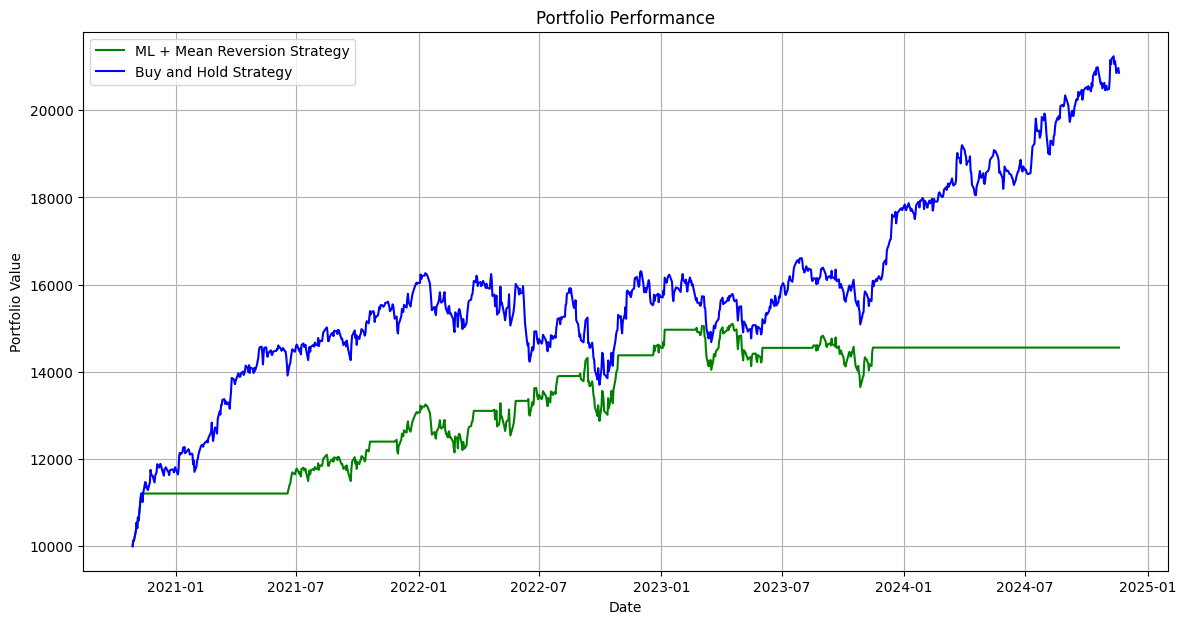

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the data
data = pd.read_csv('schd_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Calculate technical indicators
data['Daily Return'] = data['Adj_Close'].pct_change()
data['20 MA'] = data['Adj_Close'].rolling(window=20).mean()
data['20 STD'] = data['Adj_Close'].rolling(window=20).std()
data['BB High'] = data['20 MA'] + (2 * data['20 STD'])
data['BB Low'] = data['20 MA'] - (2 * data['20 STD'])
data.dropna(inplace=True)

# Step 2: Create features and target variable for ML
data['Target'] = (data['Adj_Close'].shift(-1) > data['Adj_Close']).astype(int)  # Predict price movement
features = ['Adj_Close', 'BB High', 'BB Low', 'Daily Return']
X = data[features].dropna()  # Drop NaN values
y = data.loc[X.index, 'Target']

# Step 3: Handle missing values in features
X.fillna(method='ffill', inplace=True)
X.fillna(method='bfill', inplace=True)

# Step 4: Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"ML Model Accuracy: {accuracy:.2f}")

# Step 6: Use ML predictions to refine signals
data['Prediction'] = rf_model.predict(scaler.transform(data[features].fillna(method='ffill').fillna(method='bfill')))
data['Strategy Signal'] = 0  # Initialize signals
data.loc[(data['Prediction'] == 1) & (data['Adj_Close'] < data['BB Low']), 'Strategy Signal'] = 1  # Buy signal
data.loc[(data['Prediction'] == 0) & (data['Adj_Close'] > data['BB High']), 'Strategy Signal'] = -1  # Sell signal

# Step 7: Backtest the combined strategy
initial_cash = 10_000
cash = initial_cash
shares = 0
portfolio_values = []

for i, row in data.iterrows():
    # Buy signal
    if row['Strategy Signal'] == 1:
        shares_to_buy = cash // row['Adj_Close']
        cash -= shares_to_buy * row['Adj_Close']
        shares += shares_to_buy

    # Sell signal
    elif row['Strategy Signal'] == -1 and shares > 0:
        cash += shares * row['Adj_Close']
        shares = 0

    # Calculate portfolio value
    portfolio_value = cash + shares * row['Adj_Close']
    portfolio_values.append(portfolio_value)

data['Portfolio Value'] = portfolio_values

# Step 8: Calculate buy-and-hold performance
buy_and_hold_shares = initial_cash // data.iloc[0]['Adj_Close']
buy_and_hold_cash = initial_cash - (buy_and_hold_shares * data.iloc[0]['Adj_Close'])
data['Buy and Hold Value'] = buy_and_hold_cash + buy_and_hold_shares * data['Adj_Close']

# Step 9: Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Portfolio Value'], label='ML + Mean Reversion Strategy', color='green')
plt.plot(data.index, data['Buy and Hold Value'], label='Buy and Hold Strategy', color='blue')
plt.title('Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.show()


Chart Explaination:
ML + Mean Reversion Strategy (Green Line):
This line represents the portfolio value when trading based on a combination of:
Machine Learning Predictions: Predicts whether the price will increase or decrease in the next period.
Mean Reversion Signals: Buy when the price is below the lower Bollinger Band and sell when above the upper Bollinger Band, filtered by ML predictions.
Portfolio Value includes:
Gains from trades (buy/sell signals).
Reinvestment of dividends (if incorporated in the dataset).

The blue line is just a buy and hold strategy

Lets try to improve the mean reversion steagety useing divdend reinvestment and Using our Randforest to predict the likelihood of price movement.

<ipython-input-163-cf38b21b6ec9>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='ffill', inplace=True)
<ipython-input-163-cf38b21b6ec9>:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='bfill', inplace=True)


ML Model Accuracy: 0.46


<ipython-input-163-cf38b21b6ec9>:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Prediction'] = rf_model.predict(scaler.transform(data[features].fillna(method='ffill').fillna(method='bfill')))


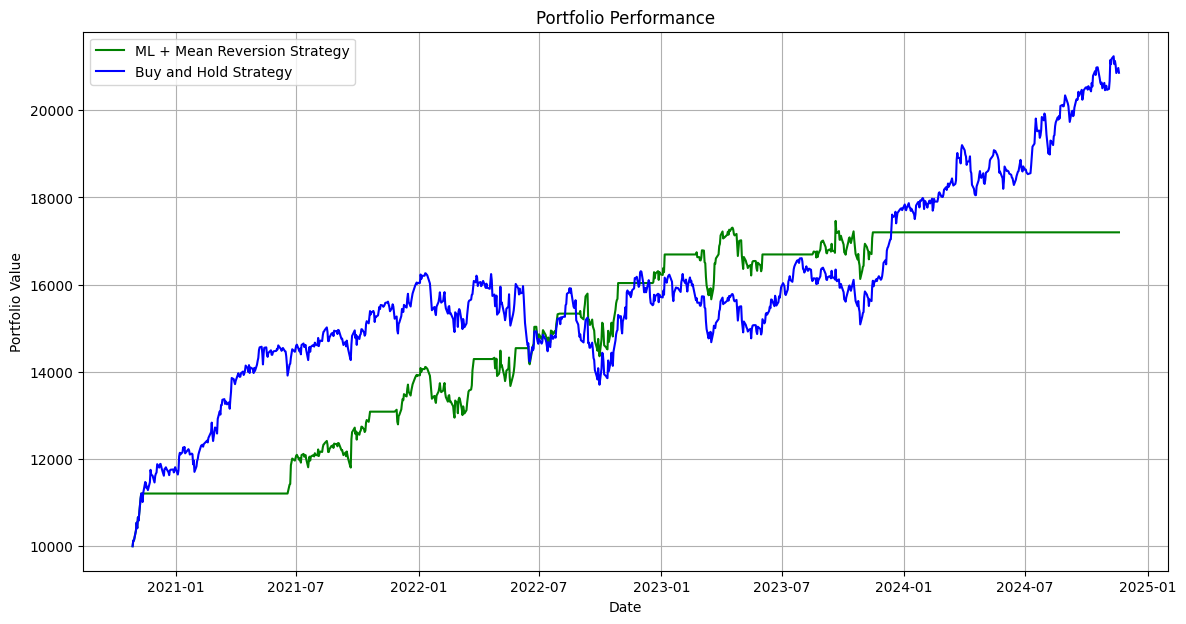

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the data
data = pd.read_csv('schd_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Calculate technical indicators
data['Daily Return'] = data['Adj_Close'].pct_change()
data['20 MA'] = data['Adj_Close'].rolling(window=20).mean()
data['20 STD'] = data['Adj_Close'].rolling(window=20).std()
data['BB High'] = data['20 MA'] + (2 * data['20 STD'])
data['BB Low'] = data['20 MA'] - (2 * data['20 STD'])
data.dropna(inplace=True)

# Step 2: Create features and target variable for ML
data['Target'] = (data['Adj_Close'].shift(-1) > data['Adj_Close']).astype(int)  # Predict price movement
features = ['Adj_Close', 'BB High', 'BB Low', 'Daily Return']
X = data[features].dropna()  # Drop NaN values
y = data.loc[X.index, 'Target']

# Step 3: Handle missing values in features
X.fillna(method='ffill', inplace=True)
X.fillna(method='bfill', inplace=True)

# Step 4: Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"ML Model Accuracy: {accuracy:.2f}")

# Step 6: Use ML predictions to refine signals
data['Prediction'] = rf_model.predict(scaler.transform(data[features].fillna(method='ffill').fillna(method='bfill')))
data['Strategy Signal'] = 0  # Initialize signals
data.loc[(data['Prediction'] == 1) & (data['Adj_Close'] < data['BB Low']), 'Strategy Signal'] = 1  # Buy signal
data.loc[(data['Prediction'] == 0) & (data['Adj_Close'] > data['BB High']), 'Strategy Signal'] = -1  # Sell signal

# Step 7: Backtest the enhanced strategy with dividend reinvestment
initial_cash = 10_000
cash = initial_cash
shares = 0
portfolio_values = []

for i, row in data.iterrows():
    # Add dividend income to cash
    dividend_income = shares * row['Dividends']  # Dividends paid for held shares
    cash += dividend_income

    # Buy signal
    if row['Strategy Signal'] == 1:
        shares_to_buy = cash // row['Adj_Close']
        cash -= shares_to_buy * row['Adj_Close']
        shares += shares_to_buy

    # Sell signal
    elif row['Strategy Signal'] == -1 and shares > 0:
        cash += shares * row['Adj_Close']
        shares = 0

    # Calculate portfolio value
    portfolio_value = cash + shares * row['Adj_Close']
    portfolio_values.append(portfolio_value)

data['Portfolio Value'] = portfolio_values

# Step 8: Calculate buy-and-hold performance
buy_and_hold_shares = initial_cash // data.iloc[0]['Adj_Close']
buy_and_hold_cash = initial_cash - (buy_and_hold_shares * data.iloc[0]['Adj_Close'])
data['Buy and Hold Value'] = buy_and_hold_cash + buy_and_hold_shares * data['Adj_Close']

# Step 9: Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Portfolio Value'], label='ML + Mean Reversion Strategy', color='green')
plt.plot(data.index, data['Buy and Hold Value'], label='Buy and Hold Strategy', color='blue')
plt.title('Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.show()


<ipython-input-173-1406876cb47e>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='ffill', inplace=True)
<ipython-input-173-1406876cb47e>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='bfill', inplace=True)


ML Model Accuracy: 0.46


<ipython-input-173-1406876cb47e>:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Prediction'] = rf_model.predict(scaler.transform(data[features].fillna(method='ffill').fillna(method='bfill')))
<ipython-input-173-1406876cb47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['Portfolio Value'] = portfolio_values
<ipython-input-173-1406876cb47e>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub

                           Portfolio Value  Buy and Hold Value
Date                                                          
2023-12-22 00:00:00+00:00   15343.013776       15149.928925   
2023-12-26 00:00:00+00:00   15343.013776       15223.775506   
2023-12-27 00:00:00+00:00   15343.013776       15235.748887   
2023-12-28 00:00:00+00:00   15343.013776       15243.732331   
2023-12-29 00:00:00+00:00   15343.013776       15205.811856   


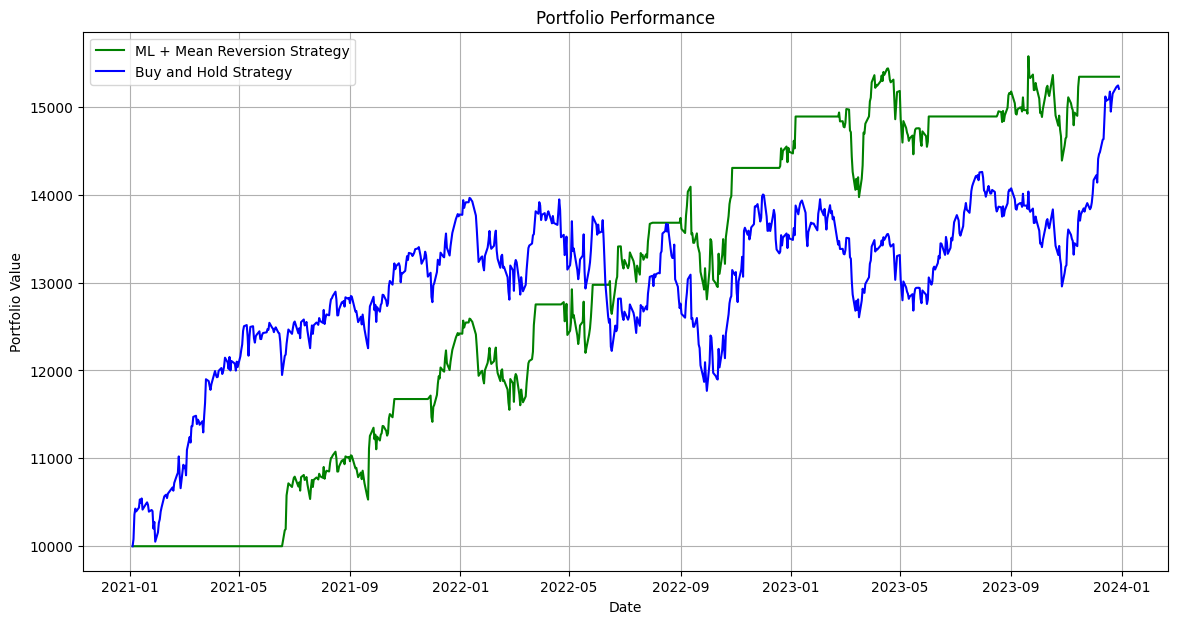

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Step 1: Load and preprocess the dataset
data = pd.read_csv('schd_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Calculate technical indicators
data['Daily Return'] = data['Adj_Close'].pct_change()
data['20 MA'] = data['Adj_Close'].rolling(window=20).mean()
data['20 STD'] = data['Adj_Close'].rolling(window=20).std()
data['BB High'] = data['20 MA'] + (2 * data['20 STD'])
data['BB Low'] = data['20 MA'] - (2 * data['20 STD'])
data.dropna(inplace=True)

# Step 2: Create features and target variable for ML
data['Target'] = (data['Adj_Close'].shift(-1) > data['Adj_Close']).astype(int)  # Predict price movement
features = ['Adj_Close', 'BB High', 'BB Low', 'Daily Return']
X = data[features].dropna()  # Drop NaN values
y = data.loc[X.index, 'Target']

# Handle missing values in features
X.fillna(method='ffill', inplace=True)
X.fillna(method='bfill', inplace=True)

# Step 3: Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"ML Model Accuracy: {accuracy:.2f}")

# Step 5: Use ML predictions to refine signals
data['Prediction'] = rf_model.predict(scaler.transform(data[features].fillna(method='ffill').fillna(method='bfill')))
data['Strategy Signal'] = 0  # Initialize signals
data.loc[(data['Prediction'] == 1) & (data['Adj_Close'] < data['BB Low']), 'Strategy Signal'] = 1  # Buy signal
data.loc[(data['Prediction'] == 0) & (data['Adj_Close'] > data['BB High']), 'Strategy Signal'] = -1  # Sell signal

# Step 6: Initialize variables for strategy simulation
initial_cash = 10_000
cash = initial_cash
shares = 0
portfolio_values = []

# Choose strategy backtest time frame
start_date = '2021-01-01'
end_date = '2024-01-01'
subset_data = data.loc[start_date:end_date]

# Iterate through each row in the chosen timeframe to simulate the strategy
for i, row in subset_data.iterrows():
    # Add dividend income to cash
    dividend_income = shares * row['Dividends']  # Dividends paid for held shares
    cash += dividend_income

    # If the ML-refined strategy signal is a buy, purchase shares
    if row['Strategy Signal'] == 1:
        shares_to_buy = cash // row['Adj_Close']
        cash -= shares_to_buy * row['Adj_Close']
        shares += shares_to_buy

    # If the ML-refined strategy signal is a sell, sell all shares
    elif row['Strategy Signal'] == -1 and shares > 0:
        cash += shares * row['Adj_Close']
        shares = 0

    # Calculate portfolio value and store it
    portfolio_value = cash + shares * row['Adj_Close']
    portfolio_values.append(portfolio_value)

# Add portfolio values to the DataFrame for the subset
subset_data['Portfolio Value'] = portfolio_values

# Calculate buy-and-hold performance for comparison
buy_and_hold_shares = initial_cash // subset_data.iloc[0]['Adj_Close']
buy_and_hold_cash = initial_cash - (buy_and_hold_shares * subset_data.iloc[0]['Adj_Close'])
subset_data['Buy and Hold Value'] = buy_and_hold_cash + buy_and_hold_shares * subset_data['Adj_Close']

# Display the last few rows of the simulation results
print(subset_data[['Portfolio Value', 'Buy and Hold Value']].tail())

# Step 7: Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(subset_data.index, subset_data['Portfolio Value'], label='ML + Mean Reversion Strategy', color='green')
plt.plot(subset_data.index, subset_data['Buy and Hold Value'], label='Buy and Hold Strategy', color='blue')
plt.title('Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.show()


**Still not preforming better than the regualr mean reversion or Buy and hold strategy**
We have some potenial reasons:

*   Overfitting in the Machine Learning Model
*   Suboptimal Features
*  Model Training Window Misalignment
* Inefficiency of Combined Signals
* Dividend Reinvestment Timing

Lets try to fix and adress some of theses issues:
First lets Visulize the differences between the Three strategys



<ipython-input-144-c31ead609d8d>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pure_subset_data['Portfolio Value'] = pure_portfolio_values
<ipython-input-144-c31ead609d8d>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pure_subset_data['Buy and Hold Value'] = pure_buy_and_hold_cash + pure_buy_and_hold_shares * pure_subset_data['Adj_Close']


                           Portfolio Value  Buy and Hold Value
Date                                                          
2023-12-22 00:00:00+00:00     14164.668398        15149.928925
2023-12-26 00:00:00+00:00     14164.668398        15223.775506
2023-12-27 00:00:00+00:00     14164.668398        15235.748887
2023-12-28 00:00:00+00:00     14164.668398        15243.732331
2023-12-29 00:00:00+00:00     14164.668398        15205.811856


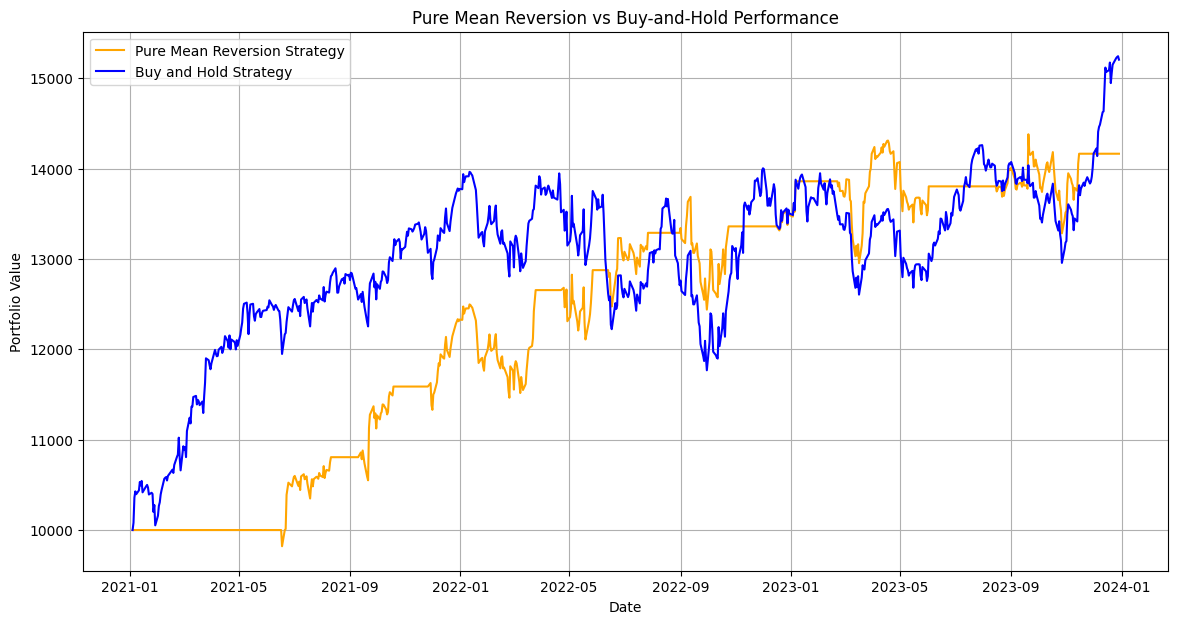

                           Portfolio Value  Buy and Hold Value
Date                                                          
2023-12-22 00:00:00+00:00     15343.013776        15149.928925
2023-12-26 00:00:00+00:00     15343.013776        15223.775506
2023-12-27 00:00:00+00:00     15343.013776        15235.748887
2023-12-28 00:00:00+00:00     15343.013776        15243.732331
2023-12-29 00:00:00+00:00     15343.013776        15205.811856


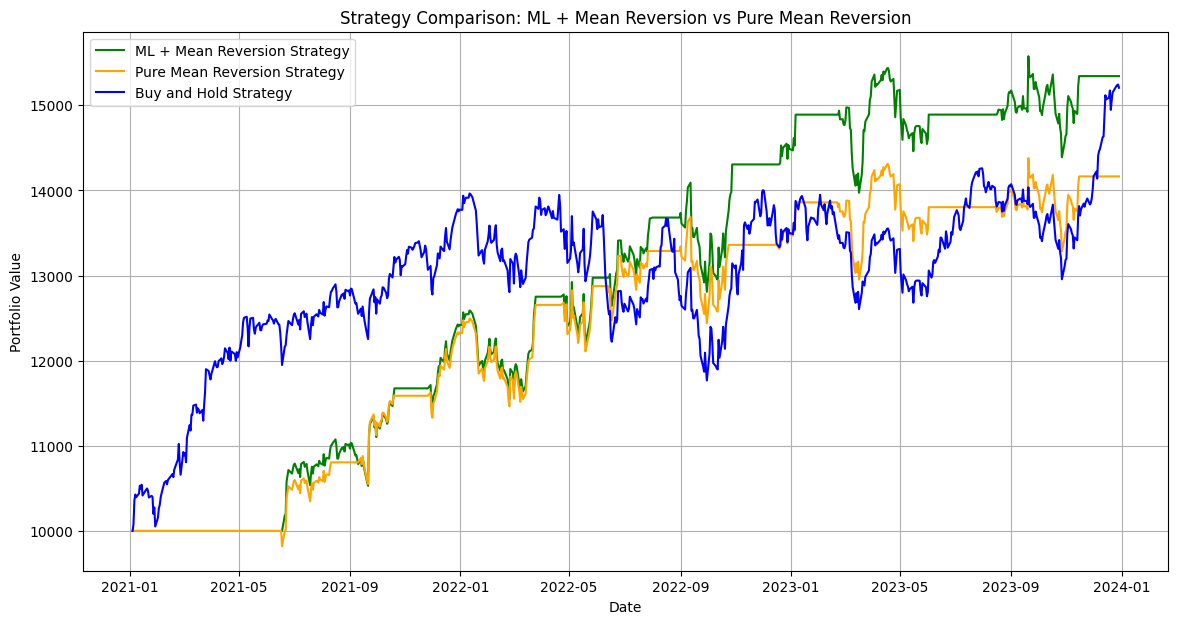

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the dataset
data = pd.read_csv('schd_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Calculate technical indicators
data['Daily Return'] = data['Adj_Close'].pct_change()
data['20 MA'] = data['Adj_Close'].rolling(window=20).mean()
data['20 STD'] = data['Adj_Close'].rolling(window=20).std()
data['BB High'] = data['20 MA'] + (2 * data['20 STD'])
data['BB Low'] = data['20 MA'] - (2 * data['20 STD'])
data.dropna(inplace=True)

# Diagnostic: Backtest pure mean reversion strategy (without ML) for comparison
initial_cash = 10_000
cash = initial_cash
shares = 0
pure_portfolio_values = []

# Use the same time frame as before
start_date = '2021-01-01'
end_date = '2024-01-01'
pure_subset_data = data.loc[start_date:end_date]

# Iterate through each row to simulate the pure mean reversion strategy
for i, row in pure_subset_data.iterrows():
    # Add dividend income to cash
    dividend_income = shares * row['Dividends']  # Dividends paid for held shares
    cash += dividend_income

    # Buy if price is below the lower Bollinger Band
    if row['Adj_Close'] < row['BB Low']:
        shares_to_buy = cash // row['Adj_Close']
        cash -= shares_to_buy * row['Adj_Close']
        shares += shares_to_buy

    # Sell if price is above the upper Bollinger Band
    elif row['Adj_Close'] > row['BB High'] and shares > 0:
        cash += shares * row['Adj_Close']
        shares = 0

    # Calculate portfolio value and store it
    portfolio_value = cash + shares * row['Adj_Close']
    pure_portfolio_values.append(portfolio_value)

# Add portfolio values to the pure strategy DataFrame
pure_subset_data['Portfolio Value'] = pure_portfolio_values

# Calculate buy-and-hold performance for comparison
pure_buy_and_hold_shares = initial_cash // pure_subset_data.iloc[0]['Adj_Close']
pure_buy_and_hold_cash = initial_cash - (pure_buy_and_hold_shares * pure_subset_data.iloc[0]['Adj_Close'])
pure_subset_data['Buy and Hold Value'] = pure_buy_and_hold_cash + pure_buy_and_hold_shares * pure_subset_data['Adj_Close']

# Display the last few rows of the pure mean reversion backtest
pure_results = pure_subset_data[['Portfolio Value', 'Buy and Hold Value']].tail()
print(pure_results)

# Visualize the pure mean reversion strategy vs buy-and-hold
plt.figure(figsize=(14, 7))
plt.plot(pure_subset_data.index, pure_subset_data['Portfolio Value'], label='Pure Mean Reversion Strategy', color='orange')
plt.plot(pure_subset_data.index, pure_subset_data['Buy and Hold Value'], label='Buy and Hold Strategy', color='blue')
plt.title('Pure Mean Reversion vs Buy-and-Hold Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.show()

# Compare pure strategy results to ML + Mean Reversion
# Assuming `subset_data` includes ML + Mean Reversion results
ml_subset_results = subset_data[['Portfolio Value', 'Buy and Hold Value']].tail()
print(ml_subset_results)

# Visualize ML + Mean Reversion vs Pure Mean Reversion
plt.figure(figsize=(14, 7))
plt.plot(subset_data.index, subset_data['Portfolio Value'], label='ML + Mean Reversion Strategy', color='green')
plt.plot(pure_subset_data.index, pure_subset_data['Portfolio Value'], label='Pure Mean Reversion Strategy', color='orange')
plt.plot(subset_data.index, subset_data['Buy and Hold Value'], label='Buy and Hold Strategy', color='blue')
plt.title('Strategy Comparison: ML + Mean Reversion vs Pure Mean Reversion')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.show()


We see that Our strategy prefroms better than both strategys both visually and numerically.

However, somthing seems off.
First of all, from our old pure mean reversion strategy we see better results, this was most likey do to the time frame as this is running only on a subset of the data.

Lets Confirm our stragety isnt over fitting and makes sense

1. Lets visulize this more to seel the buy and sell signals

2. Make sure the divident reinvestment Logic is sound

Pure Mean Reversion visulization with added dividends

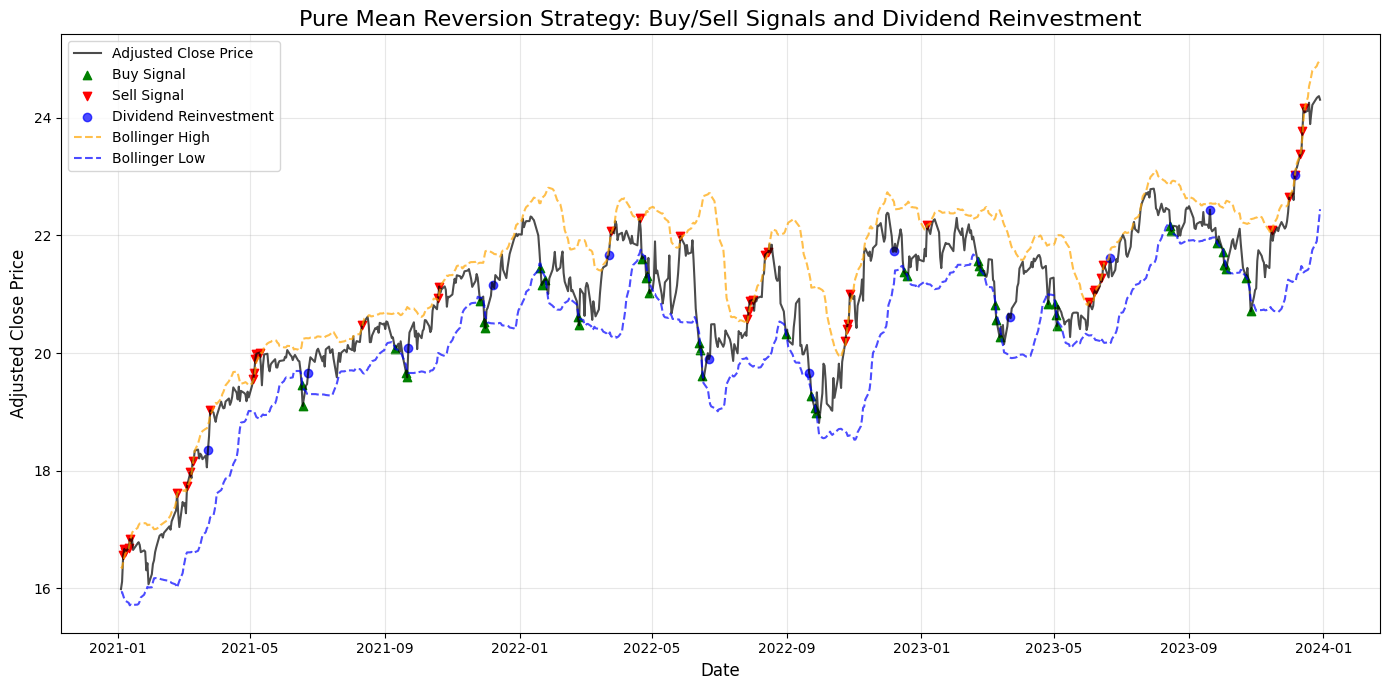

In [ ]:
import matplotlib.pyplot as plt

# Visualize buy/sell signals and dividend reinvestment for pure mean reversion strategy
plt.figure(figsize=(14, 7))

# Plot Adjusted Close prices
plt.plot(pure_subset_data.index, pure_subset_data['Adj_Close'], label='Adjusted Close Price', alpha=0.7, color='black')

# Highlight buy signals
buy_signals = pure_subset_data[pure_subset_data['Adj_Close'] < pure_subset_data['BB Low']]
plt.scatter(buy_signals.index, buy_signals['Adj_Close'], label='Buy Signal', marker='^', color='green', alpha=1)

# Highlight sell signals
sell_signals = pure_subset_data[pure_subset_data['Adj_Close'] > pure_subset_data['BB High']]
plt.scatter(sell_signals.index, sell_signals['Adj_Close'], label='Sell Signal', marker='v', color='red', alpha=1)

# Highlight dividend reinvestment points
dividend_dates = pure_subset_data[pure_subset_data['Dividends'] > 0]
plt.scatter(dividend_dates.index, dividend_dates['Adj_Close'], label='Dividend Reinvestment', marker='o', color='blue', alpha=0.7)

# Add Bollinger Bands
plt.plot(pure_subset_data.index, pure_subset_data['BB High'], label='Bollinger High', linestyle='--', color='orange', alpha=0.7)
plt.plot(pure_subset_data.index, pure_subset_data['BB Low'], label='Bollinger Low', linestyle='--', color='blue', alpha=0.7)

# Add labels and legend
plt.title('Pure Mean Reversion Strategy: Buy/Sell Signals and Dividend Reinvestment', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


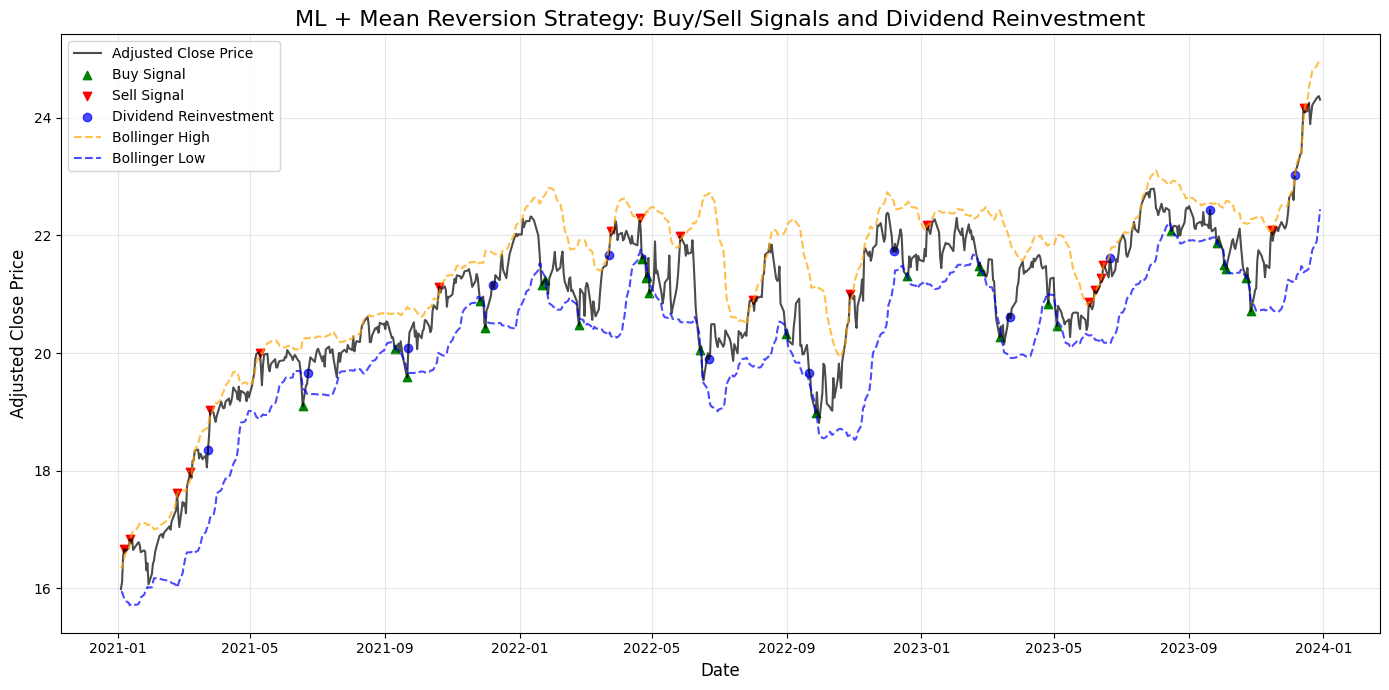

In [ ]:
import matplotlib.pyplot as plt

# Visualize buy/sell signals and dividend reinvestment for the ML + Mean Reversion strategy
plt.figure(figsize=(14, 7))

# Plot Adjusted Close prices
plt.plot(subset_data.index, subset_data['Adj_Close'], label='Adjusted Close Price', alpha=0.7, color='black')

# Highlight buy signals
buy_signals = subset_data[subset_data['Strategy Signal'] == 1]
plt.scatter(buy_signals.index, buy_signals['Adj_Close'], label='Buy Signal', marker='^', color='green', alpha=1)

# Highlight sell signals
sell_signals = subset_data[subset_data['Strategy Signal'] == -1]
plt.scatter(sell_signals.index, sell_signals['Adj_Close'], label='Sell Signal', marker='v', color='red', alpha=1)

# Highlight dividend reinvestment points
dividend_dates = subset_data[subset_data['Dividends'] > 0]
plt.scatter(dividend_dates.index, dividend_dates['Adj_Close'], label='Dividend Reinvestment', marker='o', color='blue', alpha=0.7)

# Add Bollinger Bands
plt.plot(subset_data.index, subset_data['BB High'], label='Bollinger High', linestyle='--', color='orange', alpha=0.7)
plt.plot(subset_data.index, subset_data['BB Low'], label='Bollinger Low', linestyle='--', color='blue', alpha=0.7)

# Add labels and legend
plt.title('ML + Mean Reversion Strategy: Buy/Sell Signals and Dividend Reinvestment', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Lets compare them Side by side :)

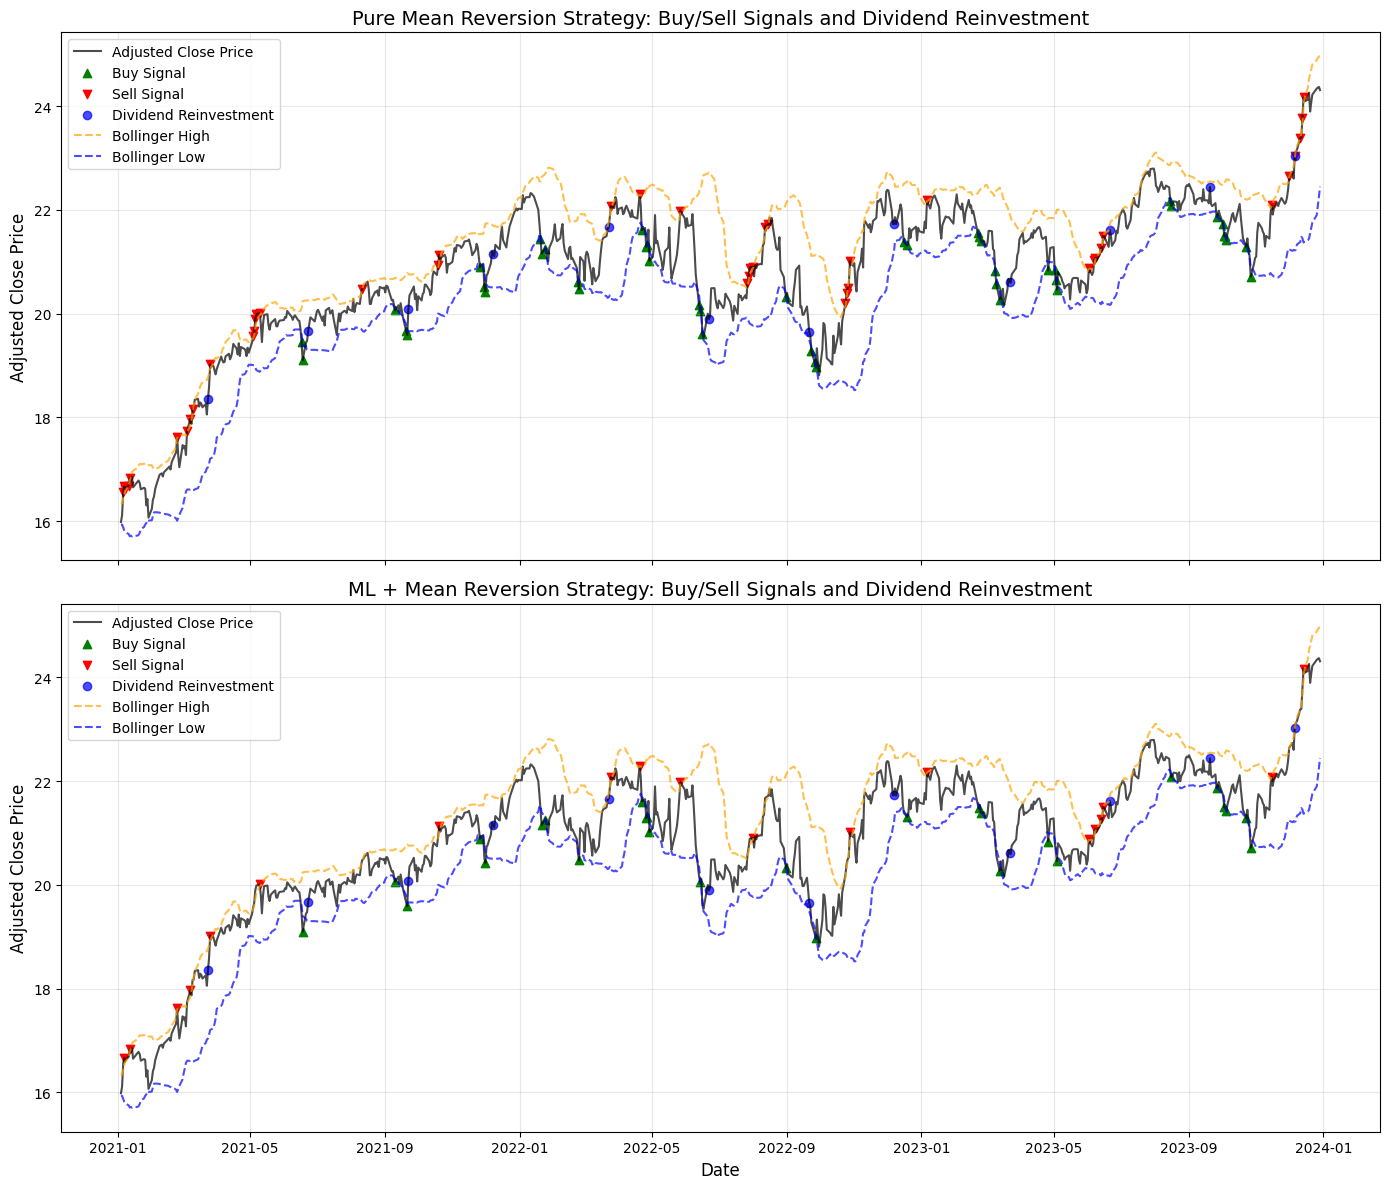

In [ ]:
import matplotlib.pyplot as plt

# Side-by-side comparison of Pure Mean Reversion and ML + Mean Reversion strategies
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot for Pure Mean Reversion Strategy
axes[0].plot(pure_subset_data.index, pure_subset_data['Adj_Close'], label='Adjusted Close Price', alpha=0.7, color='black')
buy_signals_pure = pure_subset_data[pure_subset_data['Adj_Close'] < pure_subset_data['BB Low']]
axes[0].scatter(buy_signals_pure.index, buy_signals_pure['Adj_Close'], label='Buy Signal', marker='^', color='green', alpha=1)
sell_signals_pure = pure_subset_data[pure_subset_data['Adj_Close'] > pure_subset_data['BB High']]
axes[0].scatter(sell_signals_pure.index, sell_signals_pure['Adj_Close'], label='Sell Signal', marker='v', color='red', alpha=1)
dividend_dates_pure = pure_subset_data[pure_subset_data['Dividends'] > 0]
axes[0].scatter(dividend_dates_pure.index, dividend_dates_pure['Adj_Close'], label='Dividend Reinvestment', marker='o', color='blue', alpha=0.7)
axes[0].plot(pure_subset_data.index, pure_subset_data['BB High'], label='Bollinger High', linestyle='--', color='orange', alpha=0.7)
axes[0].plot(pure_subset_data.index, pure_subset_data['BB Low'], label='Bollinger Low', linestyle='--', color='blue', alpha=0.7)
axes[0].set_title('Pure Mean Reversion Strategy: Buy/Sell Signals and Dividend Reinvestment', fontsize=14)
axes[0].set_ylabel('Adjusted Close Price', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot for ML + Mean Reversion Strategy
axes[1].plot(subset_data.index, subset_data['Adj_Close'], label='Adjusted Close Price', alpha=0.7, color='black')
buy_signals_ml = subset_data[subset_data['Strategy Signal'] == 1]
axes[1].scatter(buy_signals_ml.index, buy_signals_ml['Adj_Close'], label='Buy Signal', marker='^', color='green', alpha=1)
sell_signals_ml = subset_data[subset_data['Strategy Signal'] == -1]
axes[1].scatter(sell_signals_ml.index, sell_signals_ml['Adj_Close'], label='Sell Signal', marker='v', color='red', alpha=1)
dividend_dates_ml = subset_data[subset_data['Dividends'] > 0]
axes[1].scatter(dividend_dates_ml.index, dividend_dates_ml['Adj_Close'], label='Dividend Reinvestment', marker='o', color='blue', alpha=0.7)
axes[1].plot(subset_data.index, subset_data['BB High'], label='Bollinger High', linestyle='--', color='orange', alpha=0.7)
axes[1].plot(subset_data.index, subset_data['BB Low'], label='Bollinger Low', linestyle='--', color='blue', alpha=0.7)
axes[1].set_title('ML + Mean Reversion Strategy: Buy/Sell Signals and Dividend Reinvestment', fontsize=14)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Adjusted Close Price', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

# Final adjustments and show
plt.tight_layout()
plt.show()


1. Now lets understand what the buy and sell signal mean for our portfolio.
2. Then lets try to refine our algorithmn maybe using our ML precie prediction to scale with signal strength   ;) XD

In [ ]:
 # Ensure ML model predicts probabilities
data['Prediction Probabilities'] = rf_model.predict_proba(scaler.transform(data[features].fillna(method='ffill').fillna(method='bfill')))[:, 1]

# Generate Strategy Signal based on ML predictions and Bollinger Bands
data['Strategy Signal'] = 0  # Default to no action
data.loc[(data['Prediction Probabilities'] > 0.5) & (data['Adj_Close'] < data['BB Low']), 'Strategy Signal'] = 1  # Buy
data.loc[(data['Prediction Probabilities'] < 0.5) & (data['Adj_Close'] > data['BB High']), 'Strategy Signal'] = -1  # Sell
start_date = '2021-01-01'
end_date = '2024-01-01'
subset_data = data.loc[start_date:end_date]
print(subset_data.columns)

Index(['Adj_Close', 'Capital Gains', 'Close', 'Dividends', 'High', 'Low',
       'Open', 'Stock Splits', 'Volume', 'Daily Return', '20 MA', '20 STD',
       'BB High', 'BB Low', 'Prediction Probabilities', 'Strategy Signal'],
      dtype='object')


<ipython-input-147-e7f35ba6457f>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Prediction Probabilities'] = rf_model.predict_proba(scaler.transform(data[features].fillna(method='ffill').fillna(method='bfill')))[:, 1]


In [ ]:
# Ensure Prediction Probabilities exist in the DataFrame
if 'Prediction Probabilities' not in data.columns:
    X = data[['Adj_Close', 'BB High', 'BB Low', 'Daily Return']].fillna(method='ffill').fillna(method='bfill')
    data['Prediction Probabilities'] = rf_model.predict_proba(scaler.transform(X))[:, 1]

# Define strategy signals
data['Strategy Signal'] = 0  # Initialize to 0
data.loc[(data['Prediction Probabilities'] > 0.7) & (data['Adj_Close'] < data['BB Low']), 'Strategy Signal'] = 1  # Buy signal
data.loc[(data['Prediction Probabilities'] < 0.3) & (data['Adj_Close'] > data['BB High']), 'Strategy Signal'] = -1  # Sell signal

In [ ]:
# Initialize variables for tracking transactions
initial_cash = 10_000
cash = initial_cash
shares = 0
portfolio_values = []
transactions = []  # To store transaction details

# Use the same time frame as before
start_date = '2021-01-01'
end_date = '2024-01-01'
subset_data = data.loc[start_date:end_date]

# Iterate through each row to simulate the strategy
for i, row in subset_data.iterrows():
    # Add dividend income to cash
    dividend_income = shares * row['Dividends']
    cash += dividend_income

    # If the strategy signal is a buy, allocate based on confidence
    if row['Strategy Signal'] == 1:
        confidence = row['Prediction Probabilities']
        allocation = confidence  # Use confidence directly as allocation percentage
        shares_to_buy = int((cash * allocation) // row['Adj_Close'])
        cost = shares_to_buy * row['Adj_Close']
        if shares_to_buy > 0:
            transactions.append({'Date': i, 'Type': 'Buy', 'Shares': shares_to_buy, 'Price': row['Adj_Close'], 'Cost': cost, 'Confidence': confidence})
        cash -= cost
        shares += shares_to_buy

    # If the strategy signal is a sell, allocate based on confidence
    elif row['Strategy Signal'] == -1 and shares > 0:
        confidence = row['Prediction Probabilities']
        allocation = confidence  # Use confidence directly as allocation percentage
        shares_to_sell = int(shares * allocation)
        proceeds = shares_to_sell * row['Adj_Close']
        if shares_to_sell > 0:
            transactions.append({'Date': i, 'Type': 'Sell', 'Shares': shares_to_sell, 'Price': row['Adj_Close'], 'Proceeds': proceeds, 'Confidence': confidence})
        cash += proceeds
        shares -= shares_to_sell

    # Calculate portfolio value
    portfolio_value = cash + shares * row['Adj_Close']
    portfolio_values.append(portfolio_value)

# Add portfolio values to the DataFrame
subset_data['Portfolio Value'] = portfolio_values

# Create a transaction DataFrame
transactions_df = pd.DataFrame(transactions)
print(transactions_df)
# Display the transaction log
#import ace_tools as tools; tools.display_dataframe_to_user(name="Enhanced Strategy Transactions Log", dataframe=transactions_df)


                        Date  Type  Shares      Price         Cost  \
0  2021-06-18 00:00:00+00:00   Buy     424  19.099468  8098.174530   
1  2021-09-10 00:00:00+00:00   Buy      84  20.062361  1685.238304   
2  2021-09-21 00:00:00+00:00   Buy      17  19.587387   332.985580   
3  2021-10-20 00:00:00+00:00  Sell     141  21.130995          NaN   
4  2021-11-26 00:00:00+00:00   Buy     126  20.890438  2632.195198   
5  2021-12-01 00:00:00+00:00   Buy      33  20.425545   674.042976   
6  2022-01-21 00:00:00+00:00   Buy       8  21.157700   169.261597   
7  2022-01-24 00:00:00+00:00   Buy       1  21.244883    21.244883   
8  2022-03-25 00:00:00+00:00  Sell      71  22.080025          NaN   
9  2022-04-20 00:00:00+00:00  Sell      52  22.296764          NaN   
10 2022-04-22 00:00:00+00:00   Buy     103  21.607632  2225.586063   
11 2022-04-26 00:00:00+00:00   Buy      29  21.282513   617.192867   
12 2022-04-27 00:00:00+00:00   Buy       6  21.315859   127.895153   
13 2022-04-29 00:00:

<ipython-input-149-13457d07fe5f>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['Portfolio Value'] = portfolio_values


Lets  test this enhancement and visualize its performance compared to the earlier strategies?

In [ ]:
# Define strategy signals
data['Strategy Signal'] = 0  # Initialize to 0
data.loc[(data['Prediction Probabilities'] > 0.7) & (data['Adj_Close'] < data['BB Low']), 'Strategy Signal'] = 1  # Buy signal
data.loc[(data['Prediction Probabilities'] < 0.3) & (data['Adj_Close'] > data['BB High']), 'Strategy Signal'] = -1  # Sell signal

# Ensure no NaN values interfere with signals
data.dropna(inplace=True)

# Check for sell signals
print("Sell signals found:")
print(data[data['Strategy Signal'] == -1])

# Proceed with the strategy simulation


Sell signals found:
                           Adj_Close  Capital Gains      Close  Dividends  \
Date                                                                        
2020-11-10 00:00:00+00:00  15.383040              0  20.476667      0.000   
2021-01-07 00:00:00+00:00  16.666389              0  21.980000      0.000   
2021-01-12 00:00:00+00:00  16.833208              0  22.200001      0.000   
2021-02-24 00:00:00+00:00  17.616734              0  23.233334      0.000   
2021-03-26 00:00:00+00:00  19.022007              0  24.556667      0.000   
2021-05-10 00:00:00+00:00  20.008350              0  25.830000      0.000   
2021-10-20 00:00:00+00:00  21.130995              0  26.059999      0.000   
2022-03-25 00:00:00+00:00  22.080025              0  26.486668      0.000   
2022-04-20 00:00:00+00:00  22.296764              0  26.746668      0.000   
2022-05-27 00:00:00+00:00  21.985540              0  26.373333      0.000   
2022-08-01 00:00:00+00:00  20.906256              0  24.

In [ ]:
data.head()

,Adj_Close,Capital Gains,Close,Dividends,High,Low,Open,Stock Splits,Volume,Daily Return,20 MA,20 STD,BB High,BB Low,Prediction Probabilities,Strategy Signal
Date,,,,,,,,,,,,,,,,
2020-10-28 00:00:00+00:00,13.722778,0,18.266666,0.0,18.606667,18.243334,18.500000,0,7518900,-0.030775,14.408420,0.312818,15.034056,13.782783,0.93,1
2020-10-29 00:00:00+00:00,13.903079,0,18.506666,0.0,18.636667,18.086666,18.226667,0,5783400,0.013139,14.411550,0.307097,15.025744,13.797356,0.35,0
2020-10-30 00:00:00+00:00,13.900576,0,18.503332,0.0,18.520000,18.226667,18.393333,0,6378000,-0.000180,14.411424,0.307316,15.026056,13.796793,0.70,0
2020-11-02 00:00:00+00:00,14.211093,0,18.916668,0.0,18.953333,18.629999,18.750000,0,4733700,0.022338,14.411675,0.307141,15.025958,13.797392,0.72,0
2020-11-03 00:00:00+00:00,14.464013,0,19.253332,0.0,19.356667,19.113333,19.139999,0,4990500,0.017797,14.429204,0.299124,15.027451,13.830957,0.15,0


<ipython-input-151-b406cd8521fe>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[['Adj_Close', 'BB High', 'BB Low', 'Daily Return']].fillna(method='ffill').fillna(method='bfill')
<ipython-input-151-b406cd8521fe>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data.loc[:, 'Portfolio Value'] = portfolio_values
<ipython-input-151-b406cd8521fe>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_

                           Portfolio Value  Buy and Hold Value
Date                                                          
2024-11-13 00:00:00+00:00     21596.286989        21129.097550
2024-11-14 00:00:00+00:00     21591.866952        21034.456772
2024-11-15 00:00:00+00:00     21583.366952        20852.456772
2024-11-18 00:00:00+00:00     21588.807012        20968.938053
2024-11-19 00:00:00+00:00     21583.706960        20859.736939


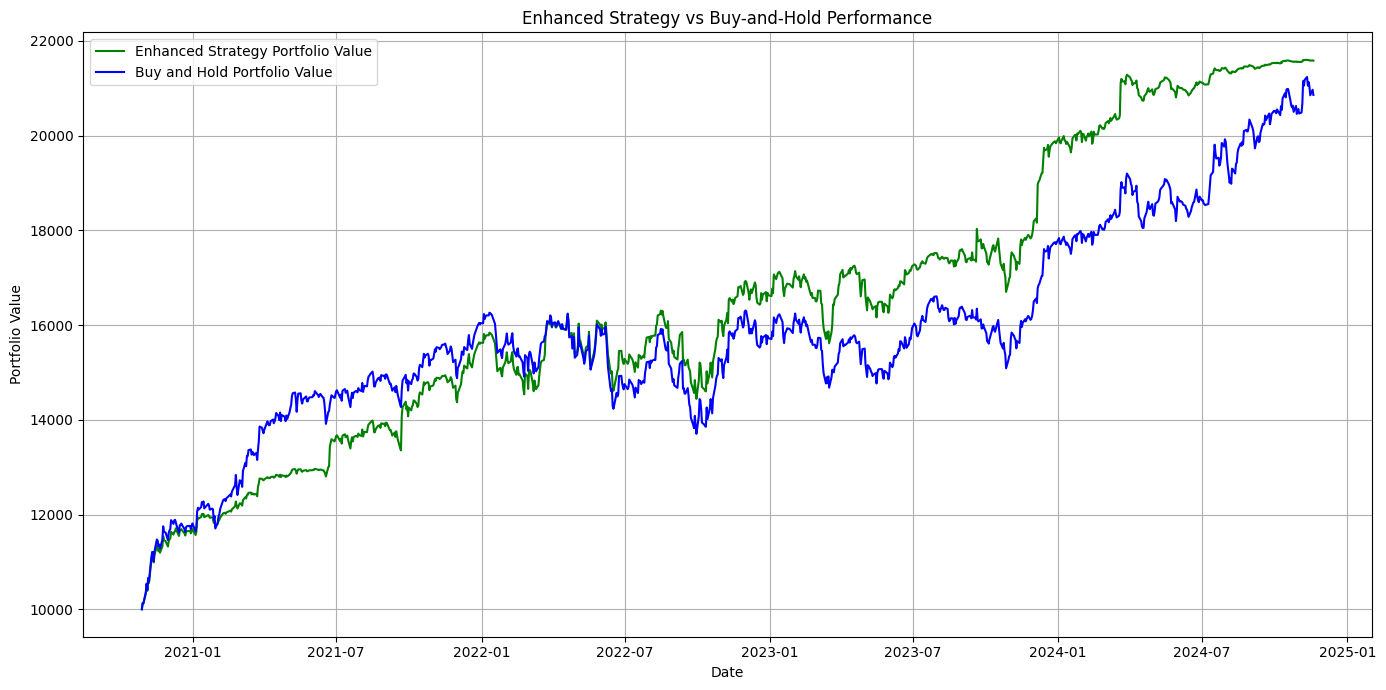

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the dataset
data = pd.read_csv('schd_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Calculate technical indicators
data['Daily Return'] = data['Adj_Close'].pct_change()
data['20 MA'] = data['Adj_Close'].rolling(window=20).mean()
data['20 STD'] = data['Adj_Close'].rolling(window=20).std()
data['BB High'] = data['20 MA'] + (2 * data['20 STD'])
data['BB Low'] = data['20 MA'] - (2 * data['20 STD'])
data.dropna(inplace=True)

# Use ML model to generate prediction probabilities if not already present
if 'Prediction Probabilities' not in data.columns:
    X = data[['Adj_Close', 'BB High', 'BB Low', 'Daily Return']].fillna(method='ffill').fillna(method='bfill')
    data['Prediction Probabilities'] = rf_model.predict_proba(scaler.transform(X))[:, 1]

# Define strategy signals
data['Strategy Signal'] = 0  # Initialize to 0
data.loc[(data['Prediction Probabilities'] > 0.7) & (data['Adj_Close'] < data['BB Low']), 'Strategy Signal'] = 1  # Buy signal
data.loc[(data['Prediction Probabilities'] < 0.3) & (data['Adj_Close'] > data['BB High']), 'Strategy Signal'] = -1  # Sell signal

# Initialize variables for tracking transactions
initial_cash = 10_000
cash = initial_cash
shares = 0
portfolio_values = []
transactions = []  # To store transaction details

# Use the same time frame as before
start_date = '2020-01-01'
end_date = '2024-11-20'
subset_data = data.loc[start_date:end_date]

# Iterate through each row to simulate the enhanced strategy
for i, row in subset_data.iterrows():
    # Add dividend income to cash
    dividend_income = shares * row['Dividends']
    cash += dividend_income

    # If the strategy signal is a buy, allocate based on confidence
    if row['Strategy Signal'] == 1:
        confidence = row['Prediction Probabilities']
        allocation = confidence  # Use confidence directly as allocation percentage
        shares_to_buy = int((cash * allocation) // row['Adj_Close'])
        cost = shares_to_buy * row['Adj_Close']
        if shares_to_buy > 0:
            transactions.append({'Date': i, 'Type': 'Buy', 'Shares': shares_to_buy, 'Price': row['Adj_Close'], 'Cost': cost, 'Confidence': confidence})
        cash -= cost
        shares += shares_to_buy

    # If the strategy signal is a sell, allocate based on confidence
    elif row['Strategy Signal'] == -1 and shares > 0:
        confidence = row['Prediction Probabilities']
        allocation = confidence  # Use confidence directly as allocation percentage
        shares_to_sell = int(shares * allocation)
        proceeds = shares_to_sell * row['Adj_Close']
        if shares_to_sell > 0:
            transactions.append({'Date': i, 'Type': 'Sell', 'Shares': shares_to_sell, 'Price': row['Adj_Close'], 'Proceeds': proceeds, 'Confidence': confidence})
        cash += proceeds
        shares -= shares_to_sell

    # Calculate portfolio value
    portfolio_value = cash + shares * row['Adj_Close']
    portfolio_values.append(portfolio_value)

# Add portfolio values to the DataFrame
subset_data.loc[:, 'Portfolio Value'] = portfolio_values

# Calculate buy-and-hold performance
buy_and_hold_shares = initial_cash // subset_data.iloc[0]['Adj_Close']
buy_and_hold_cash = initial_cash - (buy_and_hold_shares * subset_data.iloc[0]['Adj_Close'])
subset_data['Buy and Hold Value'] = buy_and_hold_cash + buy_and_hold_shares * subset_data['Adj_Close']

# Create a transaction DataFrame
transactions_df = pd.DataFrame(transactions)
portfolio_summary = subset_data[['Portfolio Value', 'Buy and Hold Value']].tail()
print(portfolio_summary)
# Display the transaction log to the user
#import ace_tools as tools; tools.display_dataframe_to_user(name="Enhanced Strategy Transactions Log", dataframe=transactions_df)

# Visualize the enhanced strategy performance vs buy-and-hold
plt.figure(figsize=(14, 7))
plt.plot(subset_data.index, subset_data['Portfolio Value'], label='Enhanced Strategy Portfolio Value', color='green')
plt.plot(subset_data.index, subset_data['Buy and Hold Value'], label='Buy and Hold Portfolio Value', color='blue')
plt.title('Enhanced Strategy vs Buy-and-Hold Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#print(transactions_df)


Looking at probability/confidence predictor and trade size.
Somthing is off with calculations

Potential Impovements:
1. dividend reivestment needs better determinsitic predictions
2. trade scaling and confidence relationship.
3. Overall market condition get into position regardles o fsigle so model doesnt get wiped out

We could try to hyperparaterize this this and fine tune it ,

Side Note: we could see how well Random forest classifiers improve dduel moving avergae crossover strategy.

But before we do this lets refine our current strategy and backtest it.
Then eventually we can backtest it with long and short position which the stragety is normally ussed for.

<ipython-input-157-c0c4dc614df5>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[['Adj_Close', 'BB High', 'BB Low', 'Daily Return']].fillna(method='ffill').fillna(method='bfill')
<ipython-input-157-c0c4dc614df5>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data.loc[:, 'Portfolio Value'] = portfolio_values
<ipython-input-157-c0c4dc614df5>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_

                           Portfolio Value  Buy and Hold Value
Date                                                          
2024-11-13 00:00:00+00:00     21596.286989        21129.097550
2024-11-14 00:00:00+00:00     21591.866952        21034.456772
2024-11-15 00:00:00+00:00     21583.366952        20852.456772
2024-11-18 00:00:00+00:00     21588.807012        20968.938053
2024-11-19 00:00:00+00:00     21583.706960        20859.736939
              Date            Type  Shares    Price       Cost      Confidence   Proceeds  
0  2020-10-28 00:00:00+00:00   Buy    684   13.722778  9386.380371     0.94             NaN
1  2020-11-10 00:00:00+00:00  Sell    143   15.383040          NaN     0.21     2199.774781
2  2021-01-07 00:00:00+00:00  Sell    129   16.666389          NaN     0.24     2149.964242
3  2021-01-12 00:00:00+00:00  Sell     70   16.833208          NaN     0.17     1178.324566
4  2021-02-24 00:00:00+00:00  Sell     88   17.616734          NaN     0.26     1550.272552
5  2021

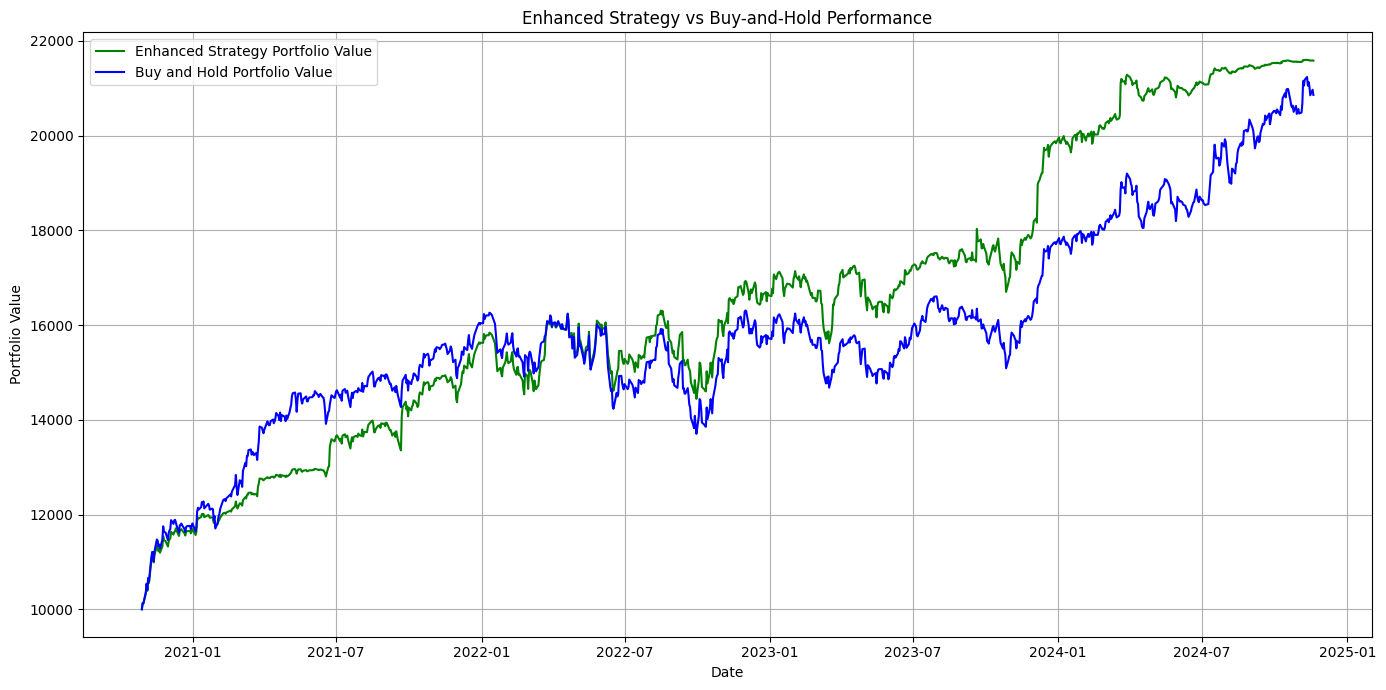

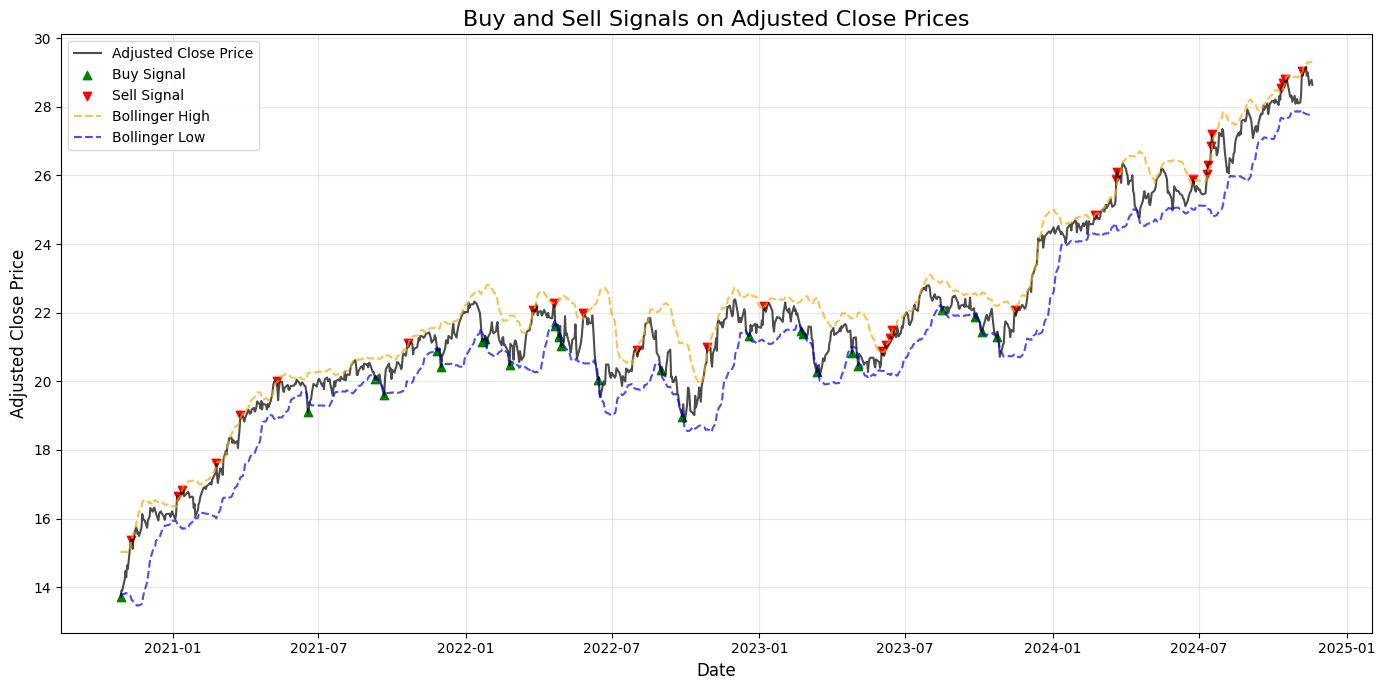

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the dataset
data = pd.read_csv('schd_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Calculate technical indicators
data['Daily Return'] = data['Adj_Close'].pct_change()
data['20 MA'] = data['Adj_Close'].rolling(window=20).mean()
data['20 STD'] = data['Adj_Close'].rolling(window=20).std()
data['BB High'] = data['20 MA'] + (2 * data['20 STD'])
data['BB Low'] = data['20 MA'] - (2 * data['20 STD'])
data.dropna(inplace=True)

# Use ML model to generate prediction probabilities if not already present
if 'Prediction Probabilities' not in data.columns:
    X = data[['Adj_Close', 'BB High', 'BB Low', 'Daily Return']].fillna(method='ffill').fillna(method='bfill')
    data['Prediction Probabilities'] = rf_model.predict_proba(scaler.transform(X))[:, 1]

# Define strategy signals
data['Strategy Signal'] = 0  # Initialize to 0
data.loc[(data['Prediction Probabilities'] > 0.7) & (data['Adj_Close'] < data['BB Low']), 'Strategy Signal'] = 1  # Buy signal
data.loc[(data['Prediction Probabilities'] < 0.3) & (data['Adj_Close'] > data['BB High']), 'Strategy Signal'] = -1  # Sell signal

# Initialize variables for tracking transactions
initial_cash = 10_000
cash = initial_cash
shares = 0
portfolio_values = []
transactions = []  # To store transaction details

# Use the same time frame as before
start_date = '2020-01-01'
end_date = '2024-11-20'
subset_data = data.loc[start_date:end_date]

# Iterate through each row to simulate the enhanced strategy
for i, row in subset_data.iterrows():
    # Add dividend income to cash
    dividend_income = shares * row['Dividends']
    cash += dividend_income

    # If the strategy signal is a buy, allocate based on confidence
    if row['Strategy Signal'] == 1:
        confidence = row['Prediction Probabilities']
        allocation = confidence  # Use confidence directly as allocation percentage
        shares_to_buy = int((cash * allocation) // row['Adj_Close'])
        cost = shares_to_buy * row['Adj_Close']
        if shares_to_buy > 0:
            transactions.append({'Date': i, 'Type': 'Buy', 'Shares': shares_to_buy, 'Price': row['Adj_Close'], 'Cost': cost, 'Confidence': confidence})
        cash -= cost
        shares += shares_to_buy

    # If the strategy signal is a sell, allocate based on confidence
    elif row['Strategy Signal'] == -1 and shares > 0:
        confidence = row['Prediction Probabilities']
        allocation = confidence  # Use confidence directly as allocation percentage
        shares_to_sell = int(shares * allocation)
        proceeds = shares_to_sell * row['Adj_Close']
        if shares_to_sell > 0:
            transactions.append({'Date': i, 'Type': 'Sell', 'Shares': shares_to_sell, 'Price': row['Adj_Close'], 'Proceeds': proceeds, 'Confidence': confidence})
        cash += proceeds
        shares -= shares_to_sell

    # Calculate portfolio value
    portfolio_value = cash + shares * row['Adj_Close']
    portfolio_values.append(portfolio_value)

# Add portfolio values to the DataFrame
subset_data.loc[:, 'Portfolio Value'] = portfolio_values

# Calculate buy-and-hold performance
buy_and_hold_shares = initial_cash // subset_data.iloc[0]['Adj_Close']
buy_and_hold_cash = initial_cash - (buy_and_hold_shares * subset_data.iloc[0]['Adj_Close'])
subset_data['Buy and Hold Value'] = buy_and_hold_cash + buy_and_hold_shares * subset_data['Adj_Close']

# Create a transaction DataFrame
transactions_df = pd.DataFrame(transactions)
portfolio_summary = subset_data[['Portfolio Value', 'Buy and Hold Value']].tail()
print(portfolio_summary)
# Adjust pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')

# Print the transactions DataFrame
print(transactions_df)

# Display the transaction log to the user
#import ace_tools as tools; tools.display_dataframe_to_user(name="Enhanced Strategy Transactions Log", dataframe=transactions_df

# Visualize the enhanced strategy performance vs buy-and-hold
plt.figure(figsize=(14, 7))
plt.plot(subset_data.index, subset_data['Portfolio Value'], label='Enhanced Strategy Portfolio Value', color='green')
plt.plot(subset_data.index, subset_data['Buy and Hold Value'], label='Buy and Hold Portfolio Value', color='blue')
plt.title('Enhanced Strategy vs Buy-and-Hold Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Visualize buy and sell signals
plt.figure(figsize=(14, 7))

# Plot Adjusted Close prices
plt.plot(subset_data.index, subset_data['Adj_Close'], label='Adjusted Close Price', alpha=0.7, color='black')

# Highlight buy signals
buy_signals = subset_data[subset_data['Strategy Signal'] == 1]
plt.scatter(buy_signals.index, buy_signals['Adj_Close'], label='Buy Signal', marker='^', color='green', alpha=1)

# Highlight sell signals
sell_signals = subset_data[subset_data['Strategy Signal'] == -1]
plt.scatter(sell_signals.index, sell_signals['Adj_Close'], label='Sell Signal', marker='v', color='red', alpha=1)

# Add Bollinger Bands
plt.plot(subset_data.index, subset_data['BB High'], label='Bollinger High', linestyle='--', color='orange', alpha=0.7)
plt.plot(subset_data.index, subset_data['BB Low'], label='Bollinger Low', linestyle='--', color='blue', alpha=0.7)

# Add labels and legend
plt.title('Buy and Sell Signals on Adjusted Close Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
